In [34]:
import tensorflow as tf

In [35]:
import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

In [36]:
import preprocessing

In [37]:
resolution = 5
length = 2000
noterange = 64

train_images = preprocessing.loadData(songLen=length)
labels = np.zeros(len(train_images))

In [38]:
songLength = int(length / resolution)
midiNotes = noterange

In [39]:
train_images = train_images.reshape(train_images.shape[0], songLength, midiNotes, 1).astype('float32')
train_images = (train_images -0.5) * 2  # Normalize the images to [-1, 1]

In [40]:
BUFFER_SIZE = 60000
BATCH_SIZE = 64

In [41]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [42]:
in_shape = [midiNotes, songLength, 1]

In [43]:
def make_generator_model():
    model = tf.keras.Sequential()
    y = int(songLength/4)
    x = int(midiNotes/4)
    model.add(layers.Dense(x*y*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((y, x, 256)))
    # assert model.output_shape == (None, 7, 7, 256)  # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5,noterange), strides=(1, 1), padding='same', use_bias=False))
    # assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(32, (5, noterange), strides=(2, 2), padding='same', use_bias=False))
    # assert model.output_shape == (None, songLength/2, midiNotes/2, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    print(model.output_shape)
    assert model.output_shape == (None, songLength,midiNotes, 1)

    return model

(None, 400, 64, 1)


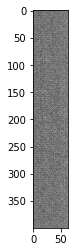

In [44]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')


In [45]:
generated_image[0, :, :, 0][0]

<tf.Tensor: shape=(64,), dtype=float32, numpy=
array([ 1.06123181e-04, -6.61244441e-04,  1.59699703e-04,  2.21117225e-04,
       -3.65064538e-04, -6.20222709e-04, -3.02039407e-05, -3.98919976e-04,
        4.24781581e-04, -1.15914336e-04,  3.80758982e-04, -4.37689567e-04,
       -2.02240160e-04, -5.13529463e-04, -4.44980658e-04, -2.37246422e-04,
        1.43829238e-04, -4.71316671e-05,  1.46081555e-04, -3.66383058e-04,
        1.36750299e-04, -3.47566995e-04, -9.39895835e-05,  1.93058513e-05,
        1.02061965e-03,  3.82233760e-04, -2.00640701e-04,  1.89552331e-04,
        5.12108090e-05, -1.50076521e-05,  7.83219293e-04,  3.48103174e-04,
        9.74117065e-05,  1.07983251e-04,  5.56059938e-04,  2.17409412e-04,
       -5.45842922e-05,  3.08217801e-04, -3.07396112e-05, -8.35186685e-04,
        1.20843906e-04, -3.32971569e-04,  3.18157225e-04, -4.66713420e-04,
        2.19004971e-04, -7.56812864e-04, -5.45689691e-05,  1.01968079e-04,
       -3.55580385e-04,  1.14653341e-03,  5.03792136e

In [46]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (3, noterange), strides=(2, 2), padding='same',
                                     input_shape=[songLength, midiNotes, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (3, noterange), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [47]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[-0.00016841]], shape=(1, 1), dtype=float32)


In [48]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)


In [49]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [50]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)


In [51]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)


In [52]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)


In [53]:
EPOCHS = 1
noise_dim = 100
num_examples_to_generate = 16

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])


In [54]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [55]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))


In [56]:
train(train_dataset, EPOCHS)

In [ ]:
tf.keras.models.save_model(generator, f"../models/gan_{EPOCHS}_generator.h5")
tf.keras.models.save_model(discriminator, f"../models/gan_{EPOCHS}_discriminator.h5")